# Проект 3. Дашборд конверсий

In [645]:
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (MO, WeekdayLocator)
from dotenv import load_dotenv

In [479]:
load_dotenv()  # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')


In [495]:
def create_visits():
    # Подготавливаем датасет с визитами
    visits = pd.DataFrame(requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END}).json())
    visits['datetime'] = pd.to_datetime(visits['datetime'])
    visits['date_group'] = pd.to_datetime(visits['datetime']).dt.date
    visits = visits[~visits['user_agent'].str.contains('bot')] # Чистим датафрейм с посещениями от ботов
    last_visits = visits.groupby(['visit_id'], as_index=False).datetime.agg('max') # Оставляем только последние визиты по Visit_id
    last_visits = last_visits.merge(visits, left_on=['visit_id','datetime'], right_on=['visit_id','datetime'],how='left')
    visits_gr = last_visits.groupby(['date_group', 'platform'],as_index=False)['visit_id']\
            .nunique().rename(columns={'visit_id':'visits'}) # Создаем сгруппированный датафрейм по дате и платформе
    visits_gr['date_group'] = pd.to_datetime(visits_gr['date_group'])
    return visits_gr

In [497]:
def create_registrations():
    # Подготавливаем датасет с регистрациями
    regs = pd.DataFrame(requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END}).json())
    regs['datetime'] = pd.to_datetime(regs['datetime'])
    regs['date_group'] = pd.to_datetime(regs['datetime']).dt.date
    regs_gr = regs.groupby(['date_group', 'platform'],as_index=False)['user_id']\
            .nunique().rename(columns={'user_id':'registrations'}) # Создаем сгруппированный датафрейм по дате и платформе
    regs_gr['date_group'] = pd.to_datetime(regs_gr['date_group'])
    return regs_gr

In [486]:
def create_merged_df(visits_gr, regs_gr):
    # Создаем объединенный датафрейм по дате и платформе и находим конверсию по дате в %
    merged_df = pd.merge(visits_gr, regs_gr,
                     how='outer',
                     left_on=['date_group', 'platform'],
                     right_on=['date_group', 'platform']
                    )
    merged_df['conversion']=merged_df['registrations']*100/merged_df['visits']
    merged_df.to_json('./conversion.json')
    return merged_df

In [488]:
def create_ads():
    # Подготавливаем датасет с рекламой
    ads = pd.read_csv('ads.csv')
    ads['date'] = pd.to_datetime(pd.to_datetime(ads['date']).dt.date)
    return ads

In [585]:
def create_merged_df_with_ads(merged_df, ads_df):
    # Создаем объединенный датафрейм по дате, визитам, регистрациям и затратам на рекламу
    result = merged_df.groupby(['date_group'], as_index=False)\
            .agg({'visits':'sum', 'registrations':'sum'})\
            .merge(ads_df, how='left', left_on='date_group', right_on='date')
    result = result[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
    result.to_json('./ads.json')
    return result

In [499]:
visits_gr = create_visits()

In [501]:
regs_gr = create_registrations()

In [503]:
merged_df = create_merged_df(visits_gr, regs_gr)

In [543]:
ads = create_ads()

In [587]:
result = create_merged_df_with_ads(merged_df, ads)

## Визуальный анализ данных

In [639]:
# Создание директории для графиков
if not os.path.exists('./charts'):
    os.makedirs('./charts')

**Распределение количества визитов по дням**

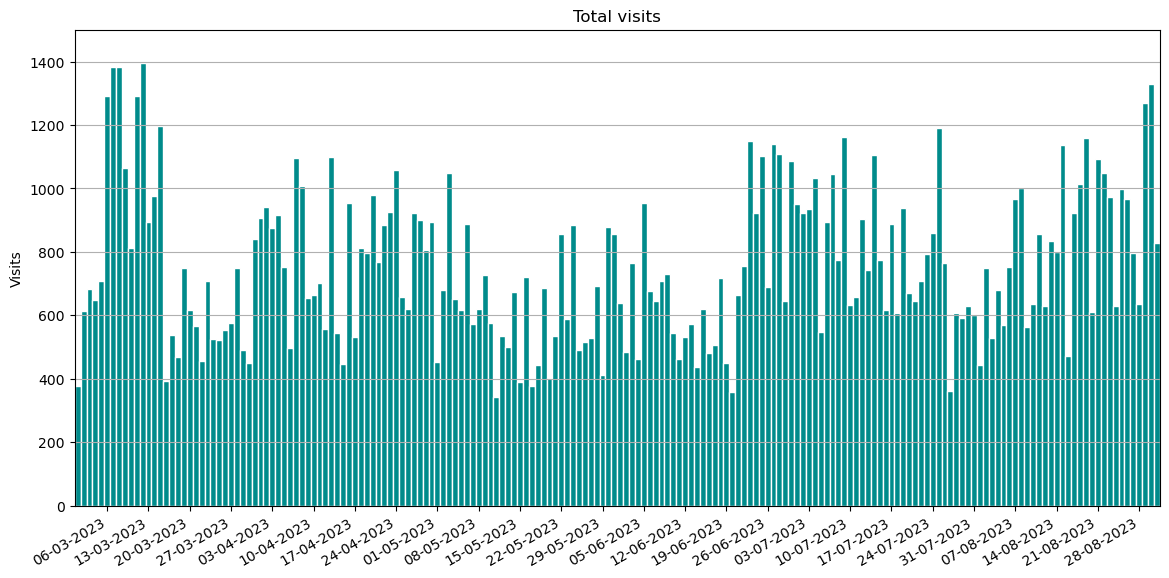

In [702]:

df = merged_df.groupby(['date_group'],as_index=False).visits.sum()
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)

# Изменим локатор, используемый по умолчанию
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
# Изменим формат календарных данных
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# Установим шрифт и поворот для меток даты
plt.gcf().autofmt_xdate()

# Отобразим данные
ax.bar(df['date_group'], df['visits'], width=1, color='darkcyan', edgecolor='white')

ax.set(ylabel='Visits', title='Total visits', ylim=(0, 1500))
ax.margins(x=0)
ax.grid(axis='y')
plt.savefig('./charts/Total_visits.png')
plt.show()

**Итоговые визиты с разбивкой по платформам**


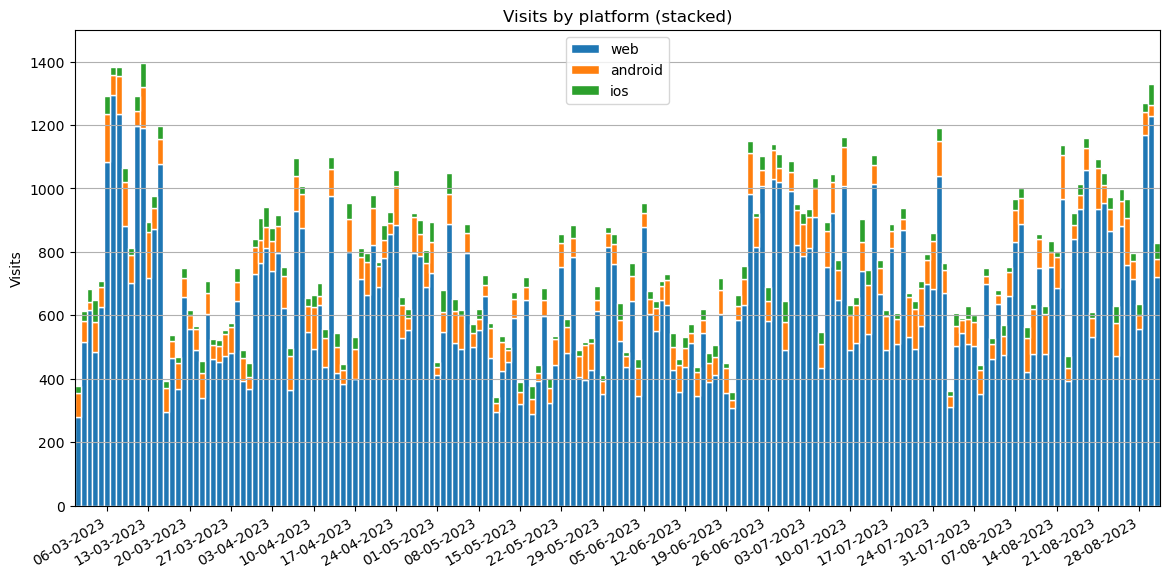

In [700]:
# Преобразуем данные в сводную таблицу, в которой названия платформ будут расположены в колонках, а даты — в строках.
df = merged_df \
    .groupby(['date_group', 'platform'], as_index=False) \
    .agg({'visits': 'sum'}) \
    .pivot(index='date_group', columns='platform', values='visits') \
    .fillna(0).astype('int') \
    .sort_index(ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(14, 7)

# Изменим локатор, используемый по умолчанию
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
# Изменим формат календарных данных
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# Установим шрифт и поворот для меток даты
plt.gcf().autofmt_xdate()

# Строим барплот с накоплением
ax.bar(df.index, df["web"], label = "web", width = 1,
      edgecolor='white') 
ax.bar(df.index, df["android"], label = "android", bottom = df.web, width = 1,
      edgecolor='white')
ax.bar(df.index, df["ios"], bottom = df.android + df.web, label = "ios", width = 1,
      edgecolor='white') 

ax.set(ylabel='Visits', title='Visits by platform (stacked)', ylim=(0, 1500))
ax.margins(x=0)
ax.legend(labels = ["web", "android", "ios"])

ax.grid(axis='y')
plt.savefig('./charts/Visits_by_platform.png')
plt.show()


**Распределение количества регистраций по дням**

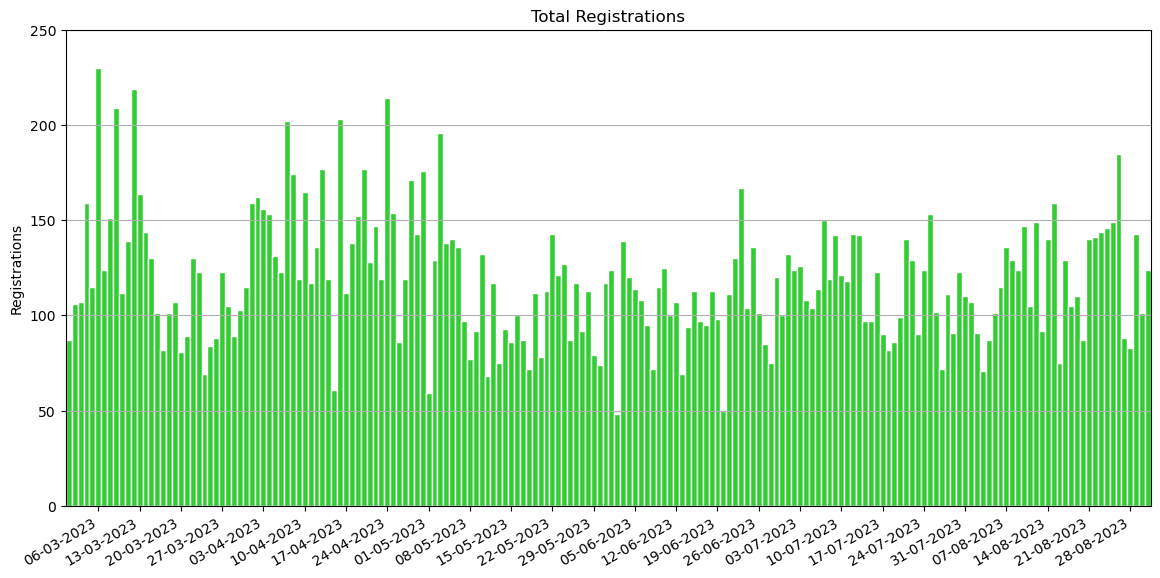

In [698]:
df = merged_df.groupby(['date_group'],as_index=False).registrations.sum()
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.bar(df['date_group'], df['registrations'], width=1, color='limegreen', edgecolor='white')

ax.set(ylabel='Registrations', title='Total Registrations', ylim=(0, 250))
ax.margins(x=0)
ax.grid(axis='y')
plt.savefig('./charts/Total_registrations.png')
plt.show()

**Итоговые регистрации с разбивкой по платформам**

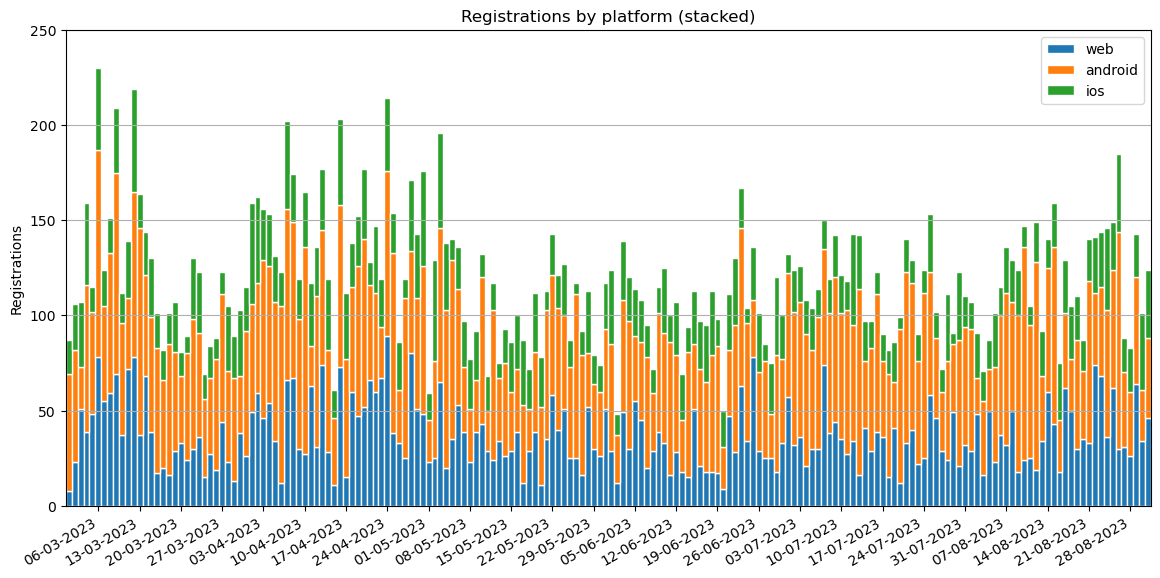

In [696]:
# Преобразуем данные в сводную таблицу, в которой названия платформ будут расположены в колонках, а даты — в строках.
df = merged_df \
    .groupby(['date_group', 'platform'], as_index=False) \
    .agg({'registrations': 'sum'}) \
    .rename(columns={'registrations': 'registrations_count'}) \
    .pivot(index='date_group', columns='platform', values='registrations_count') \
    .fillna(0).astype('int') \
    .sort_index(ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(14, 7)


ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.bar(df.index, df["web"], label = "web", width = 1,
      edgecolor='white') 
ax.bar(df.index, df["android"], label = "android", bottom = df.web, width = 1,
      edgecolor='white')
ax.bar(df.index, df["ios"], bottom = df.android + df.web, label = "ios", width = 1,
      edgecolor='white') 

ax.set(ylabel='Registrations', title='Registrations by platform (stacked)', ylim=(0, 250))

ax.legend(labels = ["web", "android", "ios"])
ax.margins(x=0)
ax.grid(axis='y')
plt.savefig('./charts/Registrations_by_platform.png')
plt.show()

**Конверсии по каждой платформе**

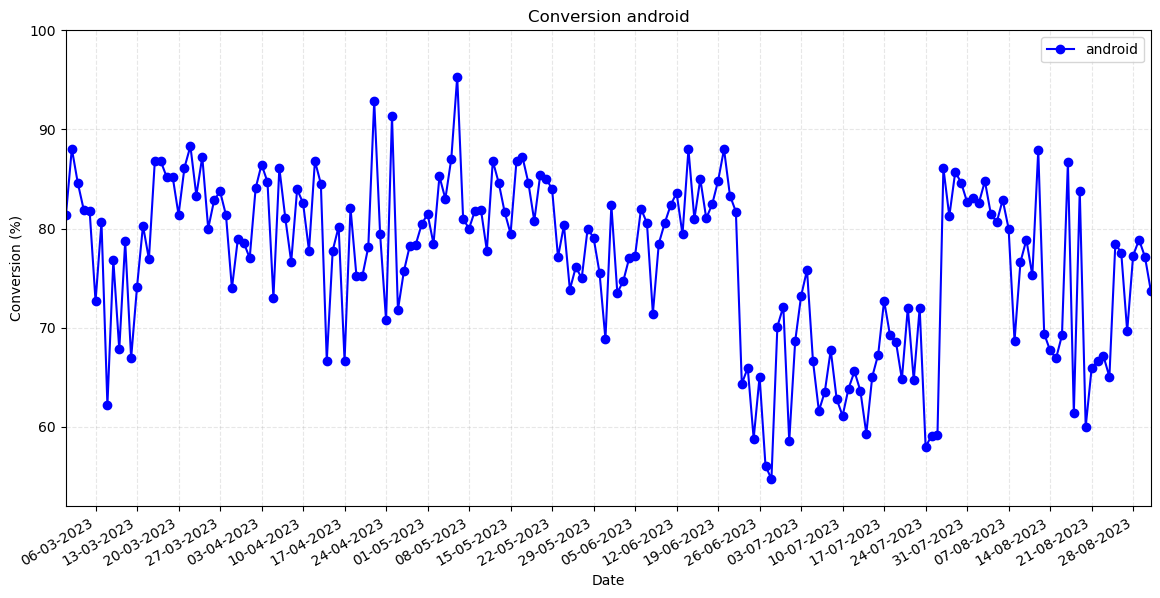

In [694]:
# Конверсия по android
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_android = merged_df[merged_df['platform'] == 'android']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date_group']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.plot(labels,
        values_android,
        # 'bo-' means blue color, round points, solid lines
        'bo-')
ax.grid(True, linestyle='--', alpha=0.3)
ax.margins(x=0)
ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion android', ylim=(52, 100))
ax.legend(["android"])
plt.savefig('./charts/Conversion_android.png')
plt.show()


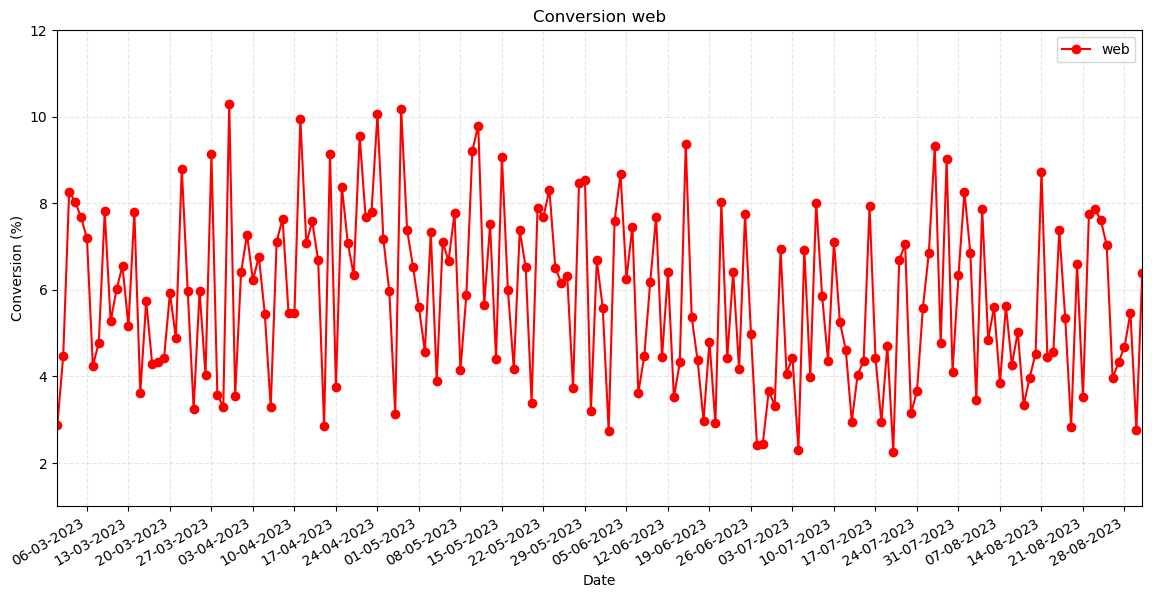

In [692]:
# Конверсия по web
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_web = merged_df[merged_df['platform'] == 'web']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date_group']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.plot(labels,
        values_web,
        'ro-')
ax.grid(True, linestyle='--', alpha=0.3)
ax.margins(x=0)
ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion web', ylim=(1, 12))
ax.legend(["web"])
plt.savefig('./charts/Conversion_web.png')
plt.show()


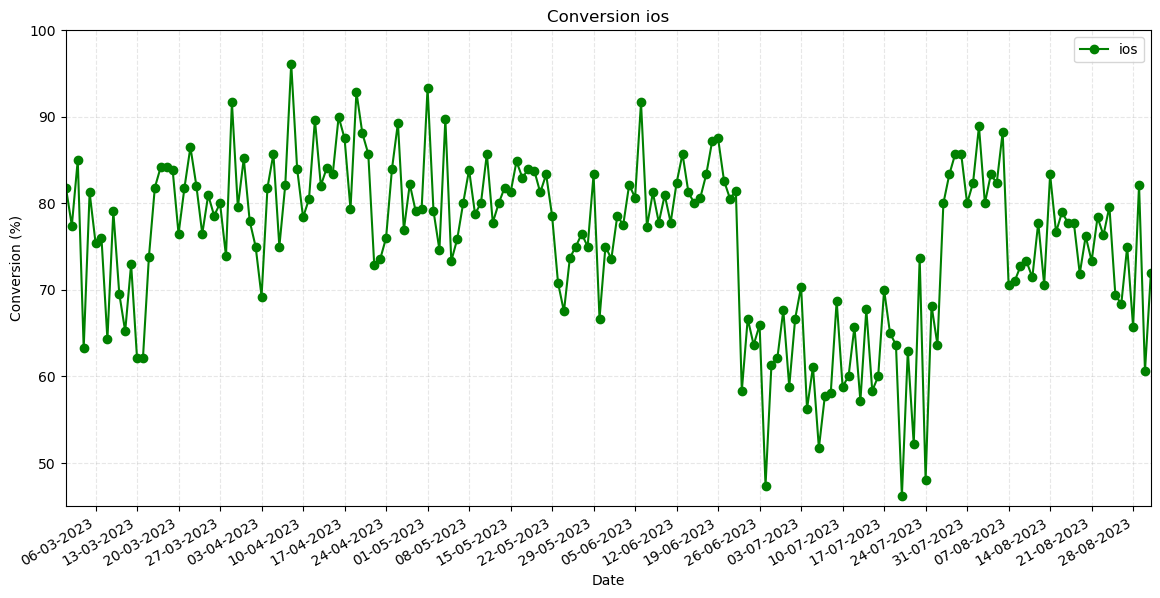

In [708]:
# Конверсия по ios
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_ios = merged_df[merged_df['platform'] == 'ios']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date_group']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()


ax.plot(labels,
        values_ios,
        'go-')
ax.grid(True, linestyle='--', alpha=0.3)
ax.margins(x=0)
ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion ios', ylim=(45, 100))
ax.legend(["ios"])
plt.savefig('./charts/Conversion_ios.png')
plt.show()


Итоговые конверсии

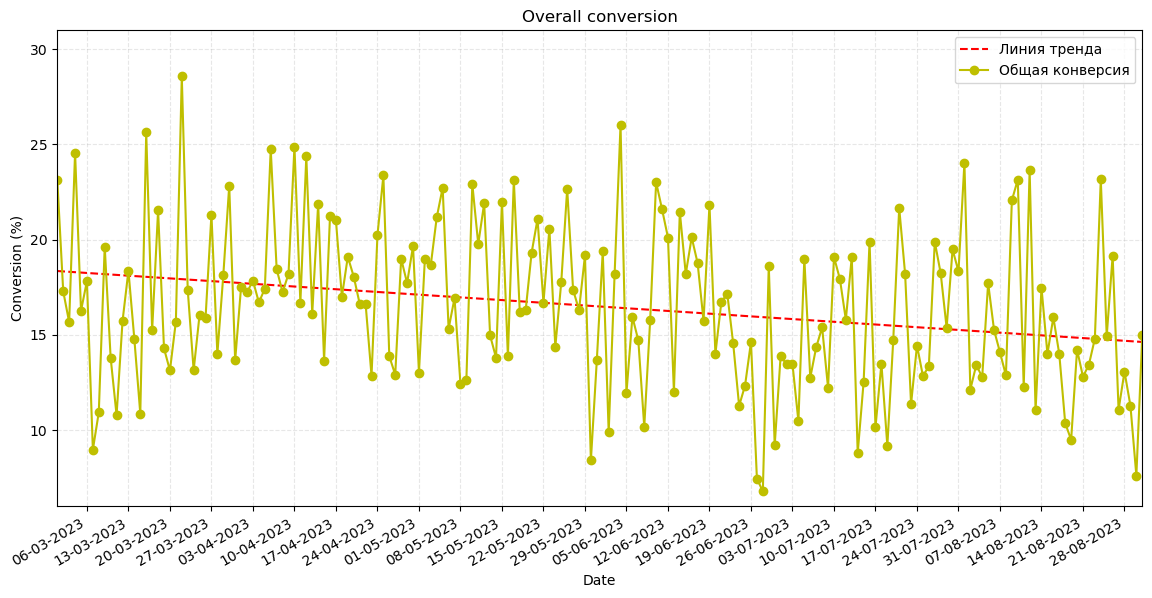

In [690]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
data = result.assign(conversion=lambda x: round(x.registrations*100/x.visits,2))

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

labels = mdates.date2num(data['date_group'])
values = data['conversion']
z = np.polyfit(labels, data['conversion'], 1)
p = np.poly1d(z)
# Рисуем линию тренда
ax.plot(labels, p(labels), "r--")

ax.plot(labels,
        values,
        'yo-')
ax.grid(True, linestyle='--', alpha=0.3)
ax.margins(x=0)
ax.set(ylabel='Conversion (%)', xlabel='Date', title='Overall conversion', ylim=(6, 31))
ax.legend(['Линия тренда', 'Общая конверсия'])
plt.savefig('./charts/Overall_conversion.png')
plt.show()

**Стоимости реклам**

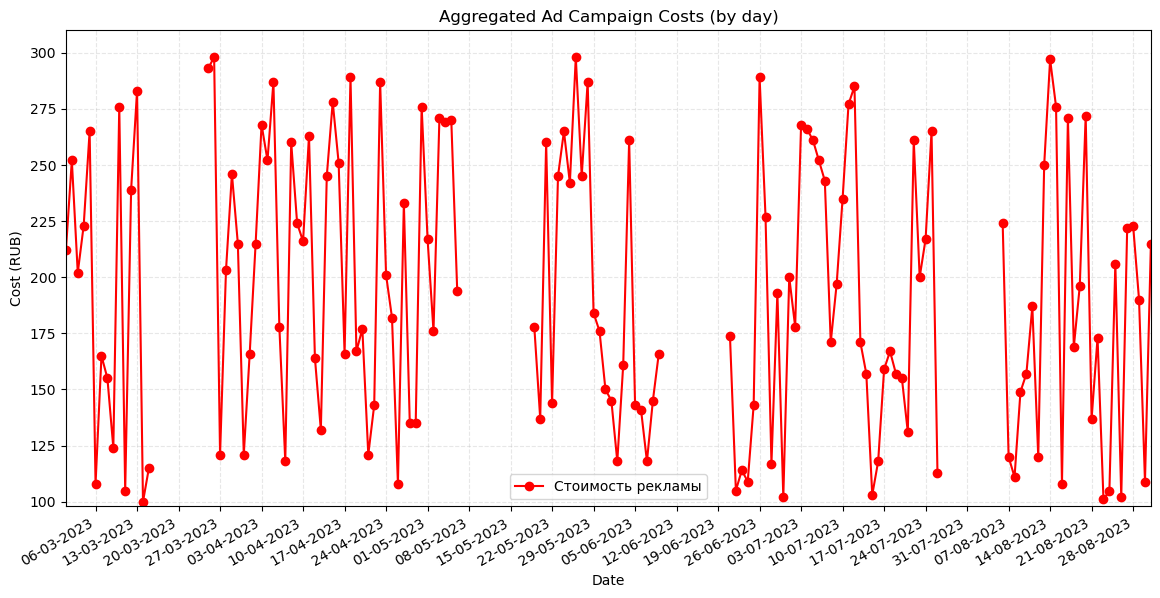

In [704]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values = result['cost']
labels = result['date_group']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.plot(labels,
        values,
        'ro-')
ax.grid(True, linestyle='--', alpha=0.3)
ax.margins(x=0)
ax.set(ylabel='Cost (RUB)', xlabel='Date', title='Aggregated Ad Campaign Costs (by day)', ylim=(98, 310))
ax.legend(["Стоимость рекламы"])
plt.savefig('./charts/Aggr_ad_cost.png')
plt.show()

Визиты и регистрации с выделением рекламных кампаний

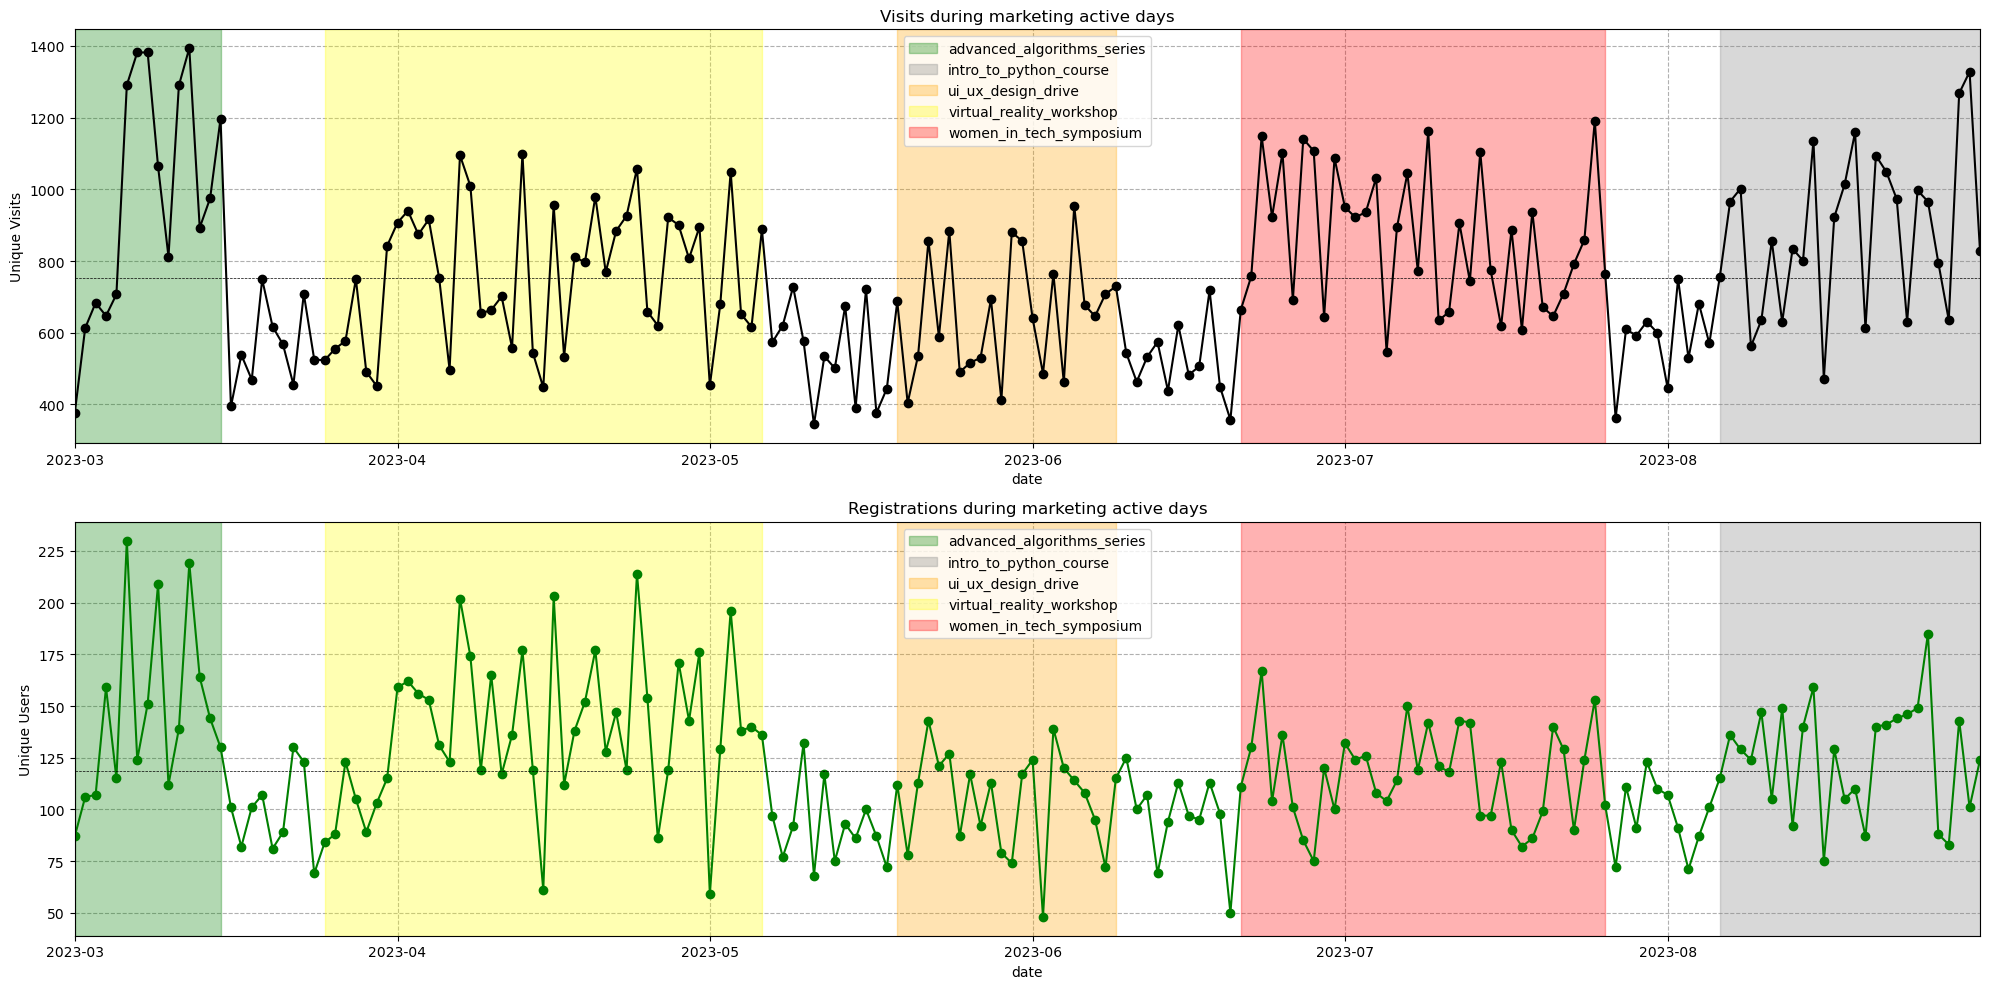

In [712]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=1, layout='tight')

color_palette = ['green','grey','orange','yellow','red']

# Датафрейм с датами начала и окончания рекламных кампаний
ads_dates = result.groupby(['utm_campaign'], as_index=False).date_group.agg(['min', 'max'])
ads_dates.sort_values(by='min')
y_1 = data['visits']
y_2 = data['registrations']
x = data['date_group']
i = j = 0


for id, row in ads_dates.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[i]
    i += 1
    ax[0].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[0].plot(x, y_1, marker='o', color='black')
ax[0].set_title('Visits during marketing active days')
ax[0].set_xlabel('date')
ax[0].set_ylabel('Unique Visits')
ax[0].margins(x=0)
ax[0].grid(True, linestyle='dashed')
ax[0].set_axisbelow(True)
ax[0].legend(loc='upper center')
ax[0].axhline(data['visits'].mean(),  color='black', linestyle='--', linewidth=0.5)

for id, row in ads_dates.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[j]
    j += 1
    ax[1].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[1].plot(x, y_2, marker='o', color='green')
ax[1].set_title('Registrations during marketing active days')
ax[1].set_xlabel('date')
ax[1].set_ylabel('Unique Users')
ax[1].margins(x=0)
ax[1].grid(True, linestyle='dashed')
ax[1].set_axisbelow(True)
ax[1].legend(loc='upper center')
ax[1].axhline(data['registrations'].mean(),  color='black', linestyle='--', linewidth=0.5)
plt.savefig('./charts/Visits_Regs_marketing.png')
plt.show()

Конверсии с разбивкой по платформам + реклама

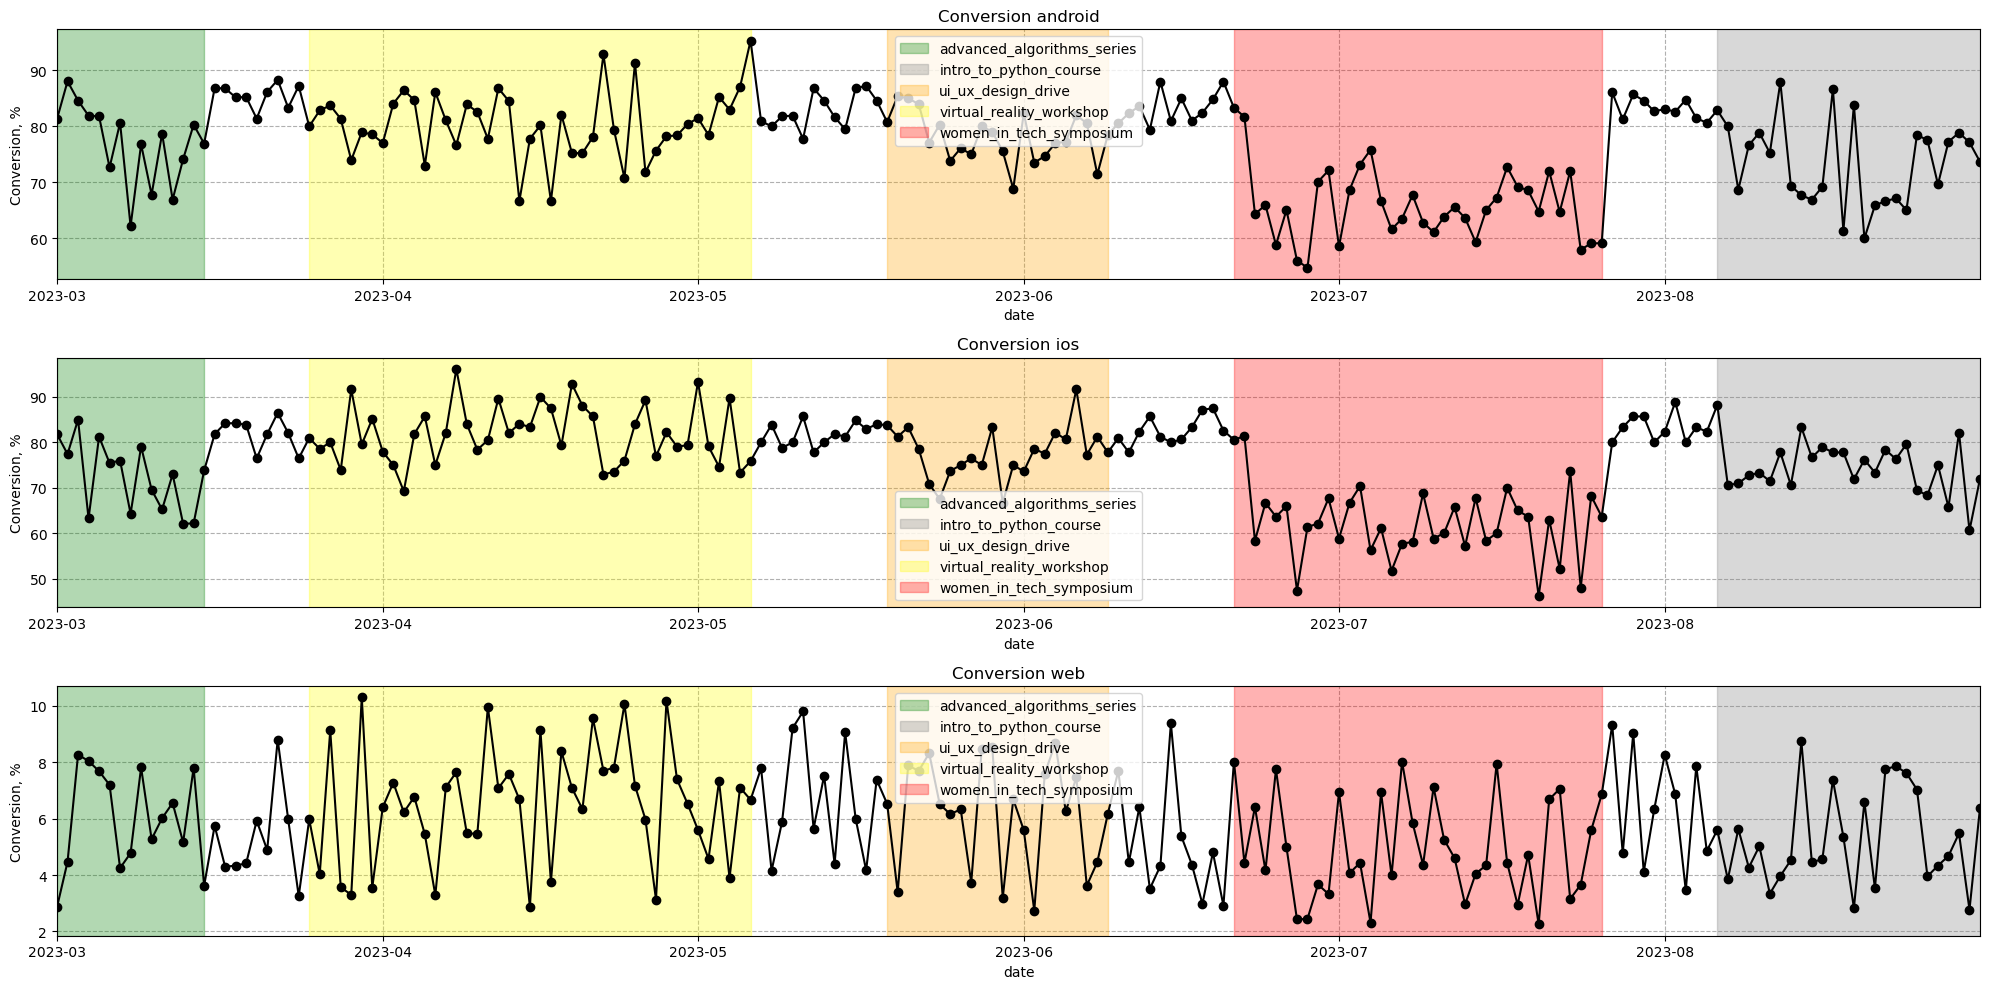

In [714]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=3, ncols=1, layout='tight')

color_palette = ['green','grey','orange','yellow','red']

# Датафрейм с датами начала и окончания рекламных кампаний
ads_dates = data.groupby(['utm_campaign'], as_index=False).date_group.agg(['min', 'max'])
ads_dates.sort_values(by='min')
values_android = merged_df[merged_df['platform'] == 'android']['conversion']
values_web = merged_df[merged_df['platform'] == 'web']['conversion']
values_ios = merged_df[merged_df['platform'] == 'ios']['conversion']
x = merged_df[merged_df['platform'] == 'android']['date_group']
k = l = m = 0

for id, row in ads_dates.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[k]
    k += 1
    ax[0].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[0].plot(x, values_android, marker='o', color='black')
ax[0].set_title('Conversion android')
ax[0].set_xlabel('date')
ax[0].set_ylabel('Conversion, %')
ax[0].margins(x=0)
ax[0].grid(True, linestyle='dashed')
ax[0].set_axisbelow(True)
ax[0].legend(loc='upper center')

for id, row in ads_dates.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[l]
    l += 1
    ax[1].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[1].plot(x, values_ios, marker='o', color='black')
ax[1].set_title('Conversion ios')
ax[1].set_xlabel('date')
ax[1].set_ylabel('Conversion, %')
ax[1].margins(x=0)
ax[1].grid(True, linestyle='dashed')
ax[1].set_axisbelow(True)
ax[1].legend(loc='lower center')

for id, row in ads_dates.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[m]
    m += 1
    ax[2].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[2].plot(x, values_web, marker='o', color='black')
ax[2].set_title('Conversion web')
ax[2].set_xlabel('date')
ax[2].set_ylabel('Conversion, %')
ax[2].margins(x=0)
ax[2].grid(True, linestyle='dashed')
ax[2].set_axisbelow(True)
ax[2].legend(loc='upper center')

plt.savefig('./charts/Conversion_platforms_marketing.png')
plt.show()